In [1]:
import os,sys
sys.path.append(os.path.abspath("../"))
import healpy as h
import collections
from modules.calc_EB_rec_noise.fast_calc_eb_rec_noise import calc_eb_rec_noise
from modules import eb_rec

from astropy.io import fits
figpath="../results/sim143/"

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
ensure_dir(figpath)

datapath=figpath + "/data_sim143/" ; ensure_dir(datapath)

%pylab notebook

def return_Nl(fwhm,noise_rms,lmax):
    ell=np.arange(lmax+1)
    noise_rms=noise_rms*(1./60.)*(np.pi/180.)
    thetab=((fwhm/60.)*np.pi/180.)/np.sqrt(8.*np.log(2))
    Bl=exp(thetab**2 *(ell*(ell+1))/2)
    return ell,noise_rms**2. * Bl**2.

Populating the interactive namespace from numpy and matplotlib


# Simulate

In [31]:
nside=512
lmax=2*nside+512
Lmax=nside

fwhm143=7.22 #arcminutes
bl143=h.gauss_beam(fwhm=(fwhm143/60.)*np.pi/180.,lmax=lmax)
Trms=0.55 # uK-deg
Prms=1.17 # uK-deg

ell,Nl_T=return_Nl(fwhm143,Trms*60.,lmax)
ell,Nl_P=return_Nl(fwhm143,Prms*60.,lmax)
Nl_thry=[Nl_T,Nl_P,Nl_P,Nl_P*0.]*(bl143**2)

clthry=np.loadtxt("../planck_cmb_cl/cmb_cl.txt")

maxell=3500
ell=clthry[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
cltt=clthry[:maxell+1,1]/fl ; cltt=append([0.,0.],cltt)
clte=clthry[:maxell+1,2]/fl ; clte=append([0.,0.],clte)
clee=clthry[:maxell+1,3]/fl ; clee=append([0.,0.],clee)
clbb=clthry[:maxell+1,4]/fl ; clbb=append([0.,0.],clbb)
ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
clthr=[cltt,clee,clbb,clte]


# Alpha power spectrum
ell=np.arange(lmax+1).astype(np.float64) 
Acb=3e-5
cl_alpha=np.zeros_like(ell) ; cl_alpha[1:]=Acb*2.*pi/(ell[1:]*(ell[1:]+1))

In [32]:
np.random.seed(0)

noise=h.synfast(Nl_thry,nside=nside,pol=True,verbose=False,new=True)
clnoise=h.alm2cl(h.map2alm(noise,lmax=lmax,pol=True))

cmb=h.synfast(clthr,nside=nside,pol=True,verbose=False,new=True)
clcmb=h.alm2cl(h.map2alm(cmb,lmax=lmax,pol=True))

alpha=h.synfast(cls=cl_alpha,nside=nside,verbose=False)
clsig=h.alm2cl(h.map2alm(alpha,lmax=lmax))

In [33]:
obs=np.zeros_like(cmb)
obs[0]=np.copy(cmb[0])
obs[1]=cmb[1]  + 2.*alpha*cmb[2]
obs[2]=cmb[2]  - 2.*alpha*cmb[1]
obs1=h.smoothing(obs,fwhm=(fwhm143/60.)*pi/180.) + noise
obs2=h.smoothing(cmb,fwhm=(fwhm143/60.)*pi/180.) + noise


/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 3.066052 arcmin (0.000892 rad) 
  sigma * 60 * 180 / np.pi, sigma
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 7.220000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [34]:
clobs1=h.alm2cl(h.map2alm(obs1,lmax=lmax,pol=True))
clobs2=h.alm2cl(h.map2alm(obs2,lmax=lmax,pol=True))

<IPython.core.display.Javascript object>


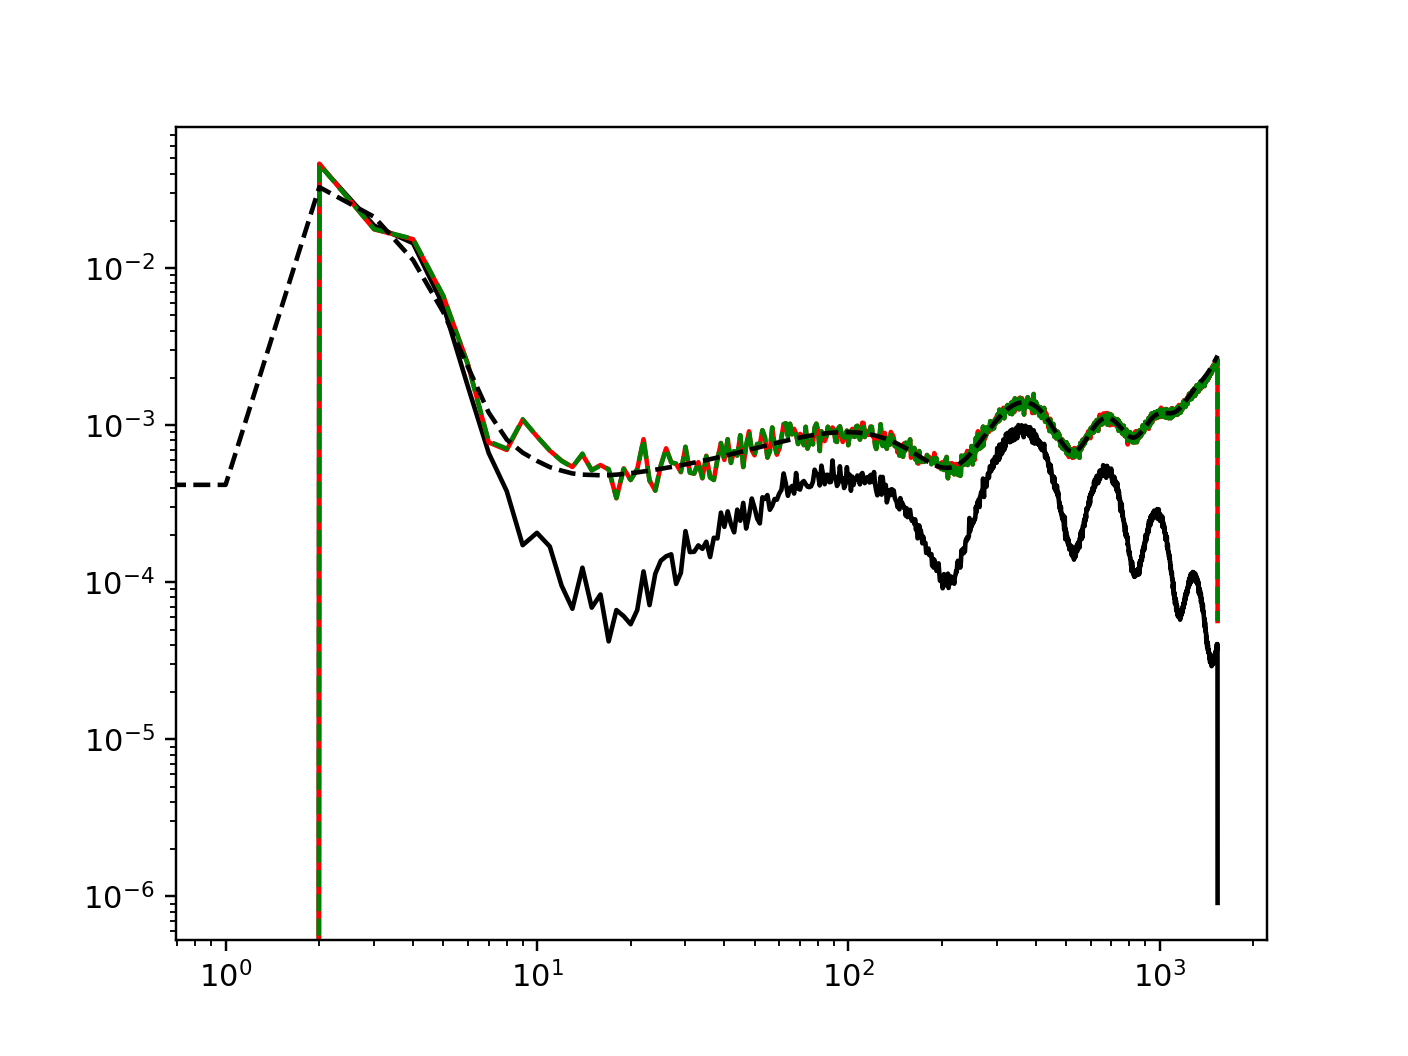

[]

In [35]:
idx=1
figure()
plot(clcmb[idx],"k-")
plot(clobs1[idx]/bl143[:lmax+1]**2,"r-")
plot(clobs2[idx]/bl143[:lmax+1]**2,"g--")
plot(clthr[idx][:lmax+1]+Nl_thry[idx][:lmax+1]/bl143[:lmax+1]**2,"k--")
loglog()

In [36]:
filename=datapath + "obs1.fits"
h.write_map(filename,obs1,overwrite=True)

filename=datapath + "obs2.fits"
h.write_map(filename,obs2,overwrite=True)

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:200: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning,


# Analyse

In [2]:
clthry=np.loadtxt("../planck_cmb_cl/cmb_cl.txt")

maxell=3500
ell=clthry[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
cltt=clthry[:maxell+1,1]/fl ; cltt=append([0.,0.],cltt)
clte=clthry[:maxell+1,2]/fl ; clte=append([0.,0.],clte)
clee=clthry[:maxell+1,3]/fl ; clee=append([0.,0.],clee)
clbb=clthry[:maxell+1,4]/fl ; clbb=append([0.,0.],clbb)
ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
clthr=[cltt,clee,clbb,clte]

fwhm143=7.22 #arcminutes
bl143=h.gauss_beam(fwhm=(fwhm143/60.)*np.pi/180.,lmax=1800)

## Unmasked analysis

In [3]:
nside=512
lmax=1024 
Lmax=512

filename=datapath + "obs1.fits"
d1=h.read_map(filename,(0,1,2))
alm=h.map2alm(d1,pol=True,lmax=lmax+256)
alm[0]=h.almxfl(alm[0],fl=1./bl143)
alm[1]=h.almxfl(alm[1],fl=1./bl143)
alm[2]=h.almxfl(alm[2],fl=1./bl143)
dec_tqu=h.alm2map(alm,pol=True,nside=nside)
# dec_tqu=h.read_map(filename,(0,1,2))

eb1=eb_rec.opt_eb_qe(dec_tqu,clthr,1024,Lmax)
eb1.eb_reconstruct()

#------------------------------------------------------
filename=datapath + "obs2.fits"
d1=h.read_map(filename,(0,1,2))
alm=h.map2alm(d1,pol=True,lmax=lmax+256)
alm[0]=h.almxfl(alm[0],fl=1./bl143)
alm[1]=h.almxfl(alm[1],fl=1./bl143)
alm[2]=h.almxfl(alm[2],fl=1./bl143)
dec_tqu=h.alm2map(alm,pol=True,nside=nside)
# dec_tqu=h.read_map(filename,(0,1,2))

eb2=eb_rec.opt_eb_qe(dec_tqu,clthr,1024,Lmax)
eb2.eb_reconstruct()

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigm

<IPython.core.display.Javascript object>


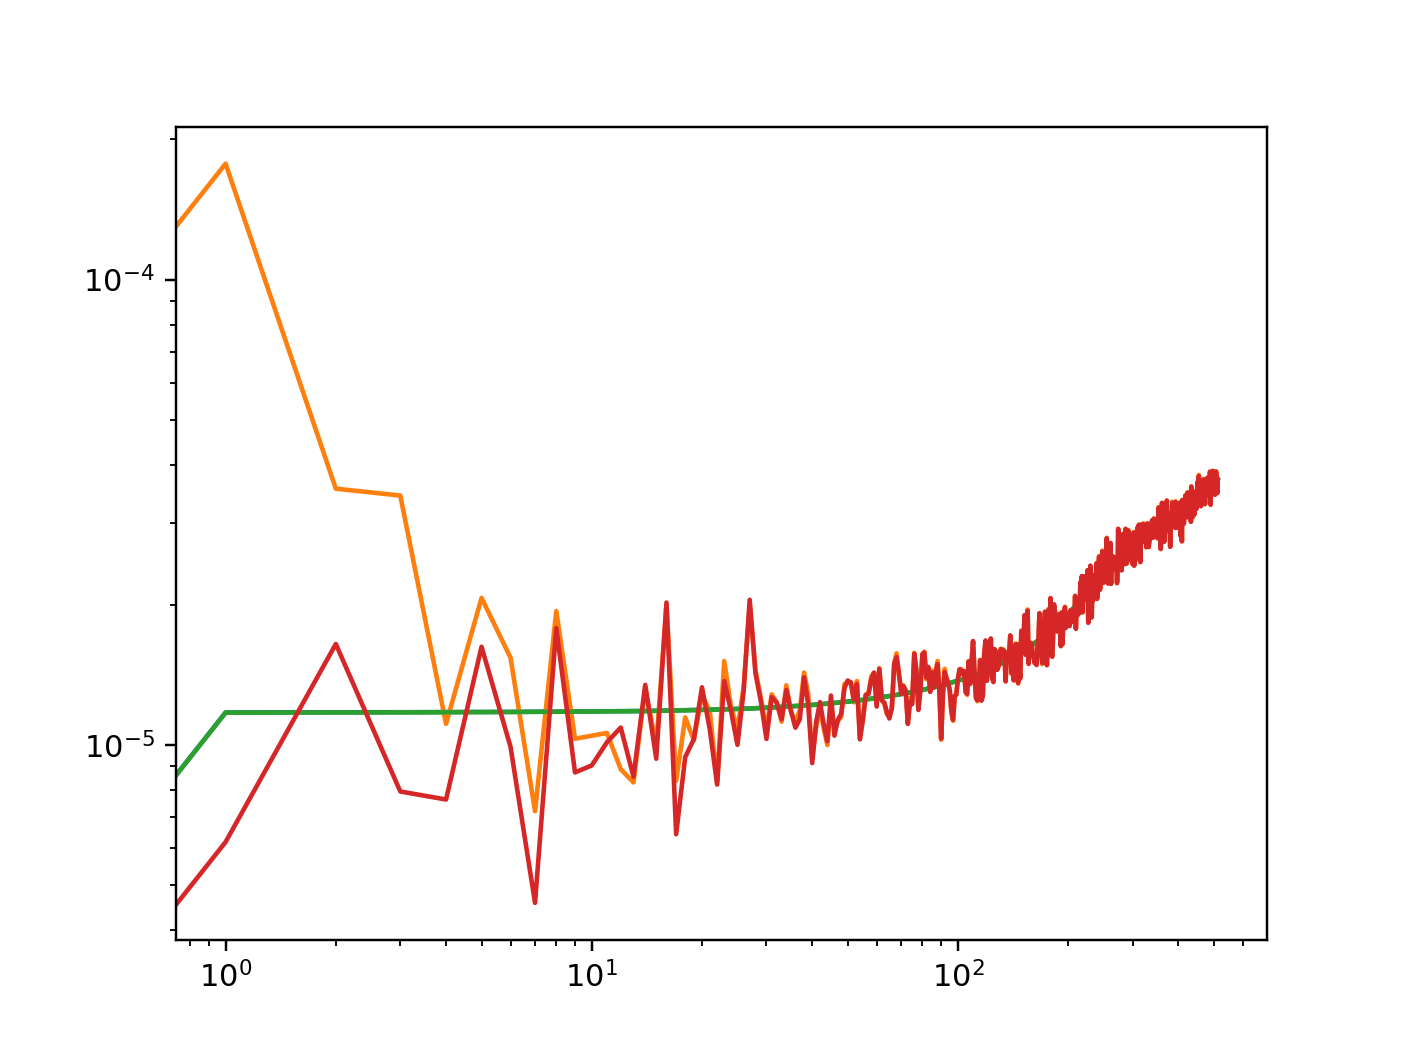

[]

In [4]:
figure()
plot(eb1.N_L)
plot(eb1.Cl_rec_alpha)
plot(eb2.N_L)
plot(eb2.Cl_rec_alpha)
loglog()
loglog()

<IPython.core.display.Javascript object>


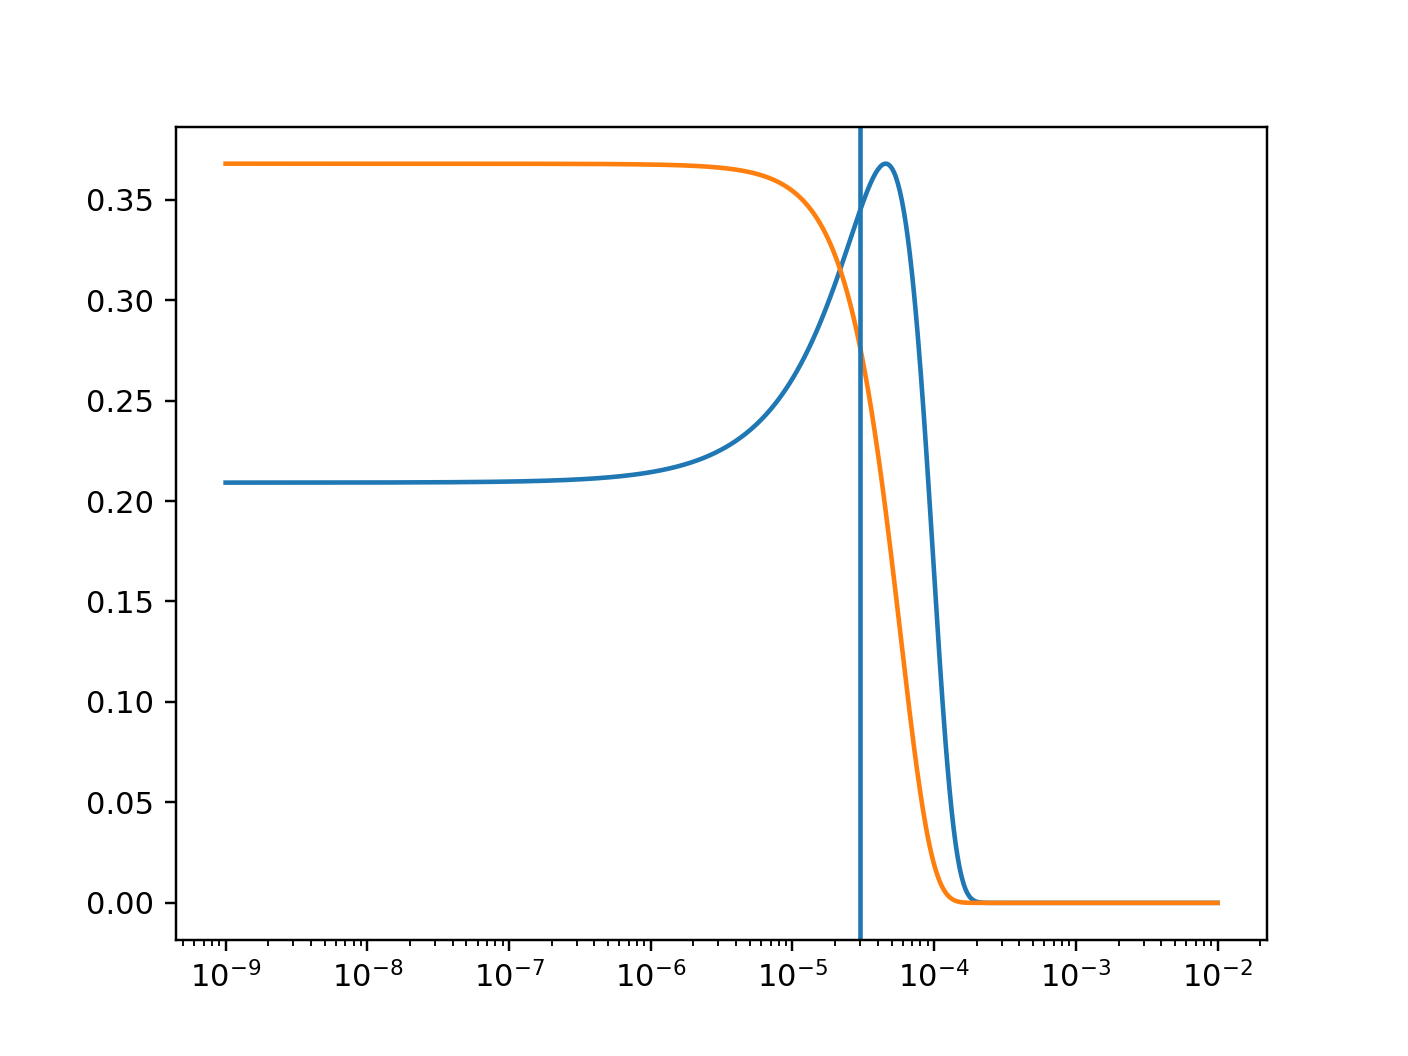

In [5]:
L=np.arange(Lmax+1)
clmodel=np.zeros(Lmax+1,np.float64)
clmodel[1:]=2.*pi/(L[1:]*(L[1:]+1))

def bire_lkl(A,Clobs,Nl,clthry,fsky,Lmax):
    L=np.arange(Lmax+1)
    var=(2./((2.*L+1)*fsky))*Nl[:Lmax+1]**2.
    chi2=np.sum((Clobs[1:Lmax+1]-Nl[1:Lmax+1]-A*clthry[1:Lmax+1])**2/var[1:Lmax+1])
    return chi2

Avals=np.logspace(-9,-2,1000)

chi1=np.zeros_like(Avals)
chi2=np.zeros_like(Avals)
for i,A in enumerate(Avals):
    chi1[i]=bire_lkl(A,eb1.Cl_rec_alpha,eb1.N_L,clmodel,1.,512)
    chi2[i]=bire_lkl(A,eb2.Cl_rec_alpha,eb2.N_L,clmodel,1.,512)
    
    
chi1=chi1/min(chi1)
chi2=chi2/min(chi2)
figure()
plot(Avals,exp(-chi1))
plot(Avals,exp(-chi2))
semilogx()
axvline(3e-5)

## Masked analysis

In [70]:
nside=512
lmax=1024 
Lmax=512


maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits"
mask78=h.read_map(maskname,dtype=np.float64,verbose=False)
mask78=h.ud_grade(mask78,nside)
fsky78=sum(mask78)/size(mask78)


# maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
# # maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits"
# mask78=h.read_map(maskname,4,dtype=np.float64,verbose=False)
# mask78=h.ud_grade(mask78,nside)
# fsky78=sum(mask78)/size(mask78)
# print(fsky78)

filename=datapath + "obs1.fits"
d1=h.read_map(filename,(0,1,2))
alm=h.map2alm(d1,pol=True,lmax=lmax+256)
alm[0]=h.almxfl(alm[0],fl=1./bl143)
alm[1]=h.almxfl(alm[1],fl=1./bl143)
alm[2]=h.almxfl(alm[2],fl=1./bl143)
dec_tqu=h.alm2map(alm,pol=True,nside=nside)
# dec_tqu=h.read_map(filename,(0,1,2))

eb1=eb_rec.opt_eb_qe(dec_tqu,clthr,1024,Lmax,mask=mask78)
eb1.eb_reconstruct()

#------------------------------------------------------
filename=datapath + "obs2.fits"
d1=h.read_map(filename,(0,1,2))
alm=h.map2alm(d1,pol=True,lmax=lmax+256)
alm[0]=h.almxfl(alm[0],fl=1./bl143)
alm[1]=h.almxfl(alm[1],fl=1./bl143)
alm[2]=h.almxfl(alm[2],fl=1./bl143)
dec_tqu=h.alm2map(alm,pol=True,nside=nside)
# dec_tqu=h.read_map(filename,(0,1,2))

eb2=eb_rec.opt_eb_qe(dec_tqu,clthr,1024,Lmax,mask=mask78)
eb2.eb_reconstruct()

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/opt/anaconda3/envs/hp/lib

<IPython.core.display.Javascript object>


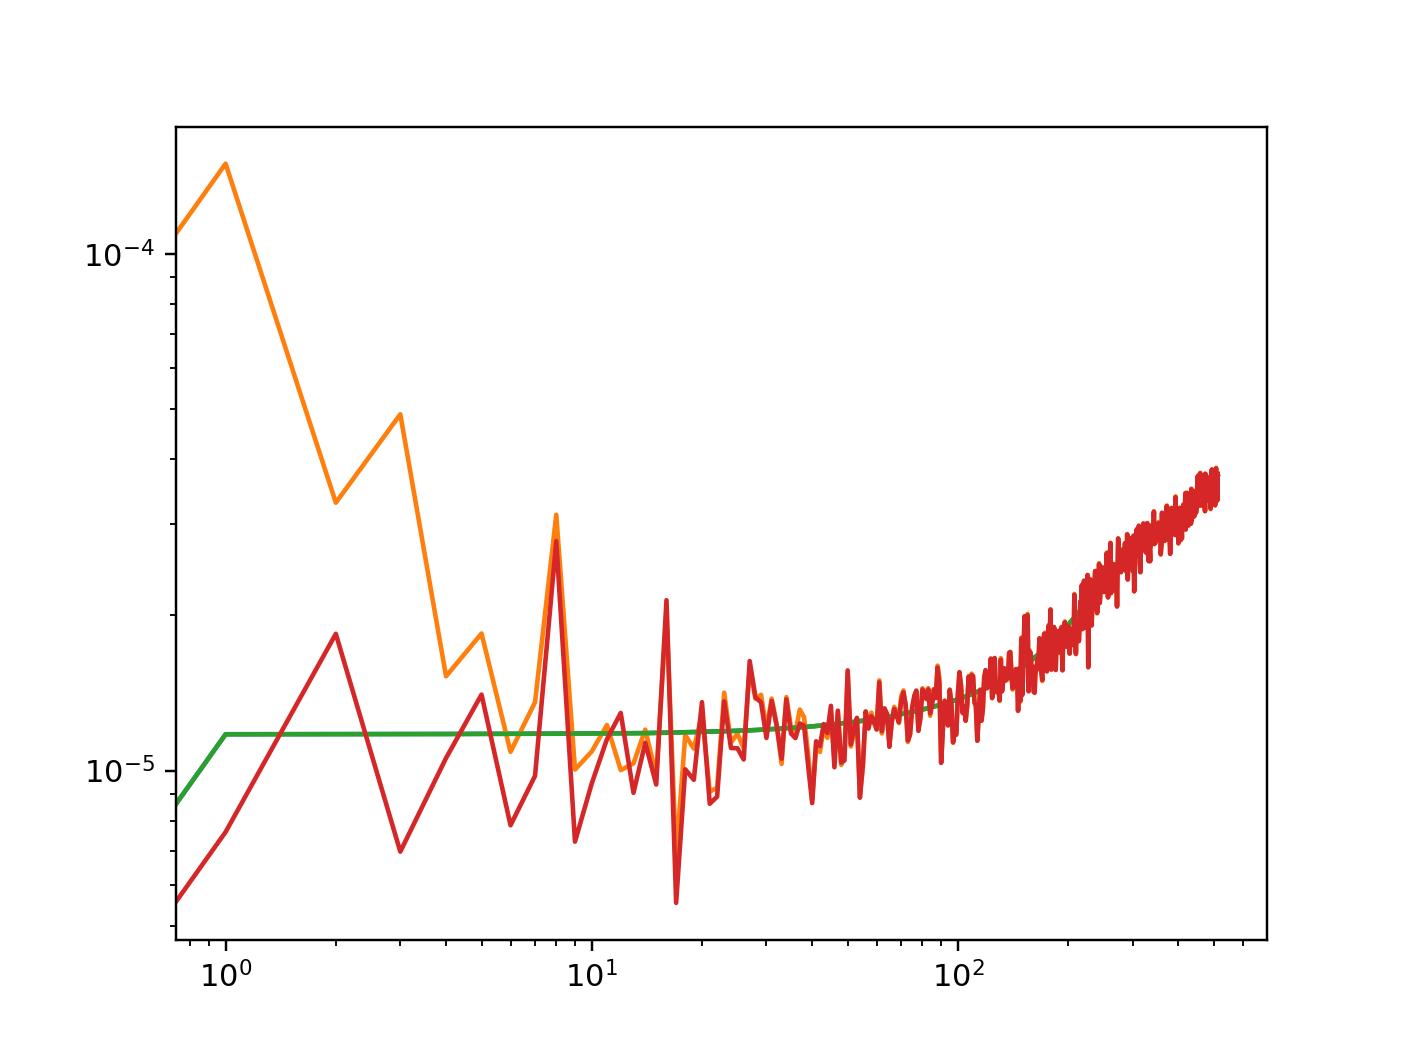

[]

In [71]:
figure()
plot(eb1.N_L)
plot(eb1.Cl_rec_alpha)
plot(eb2.N_L)
plot(eb2.Cl_rec_alpha)
loglog()
loglog()

<IPython.core.display.Javascript object>


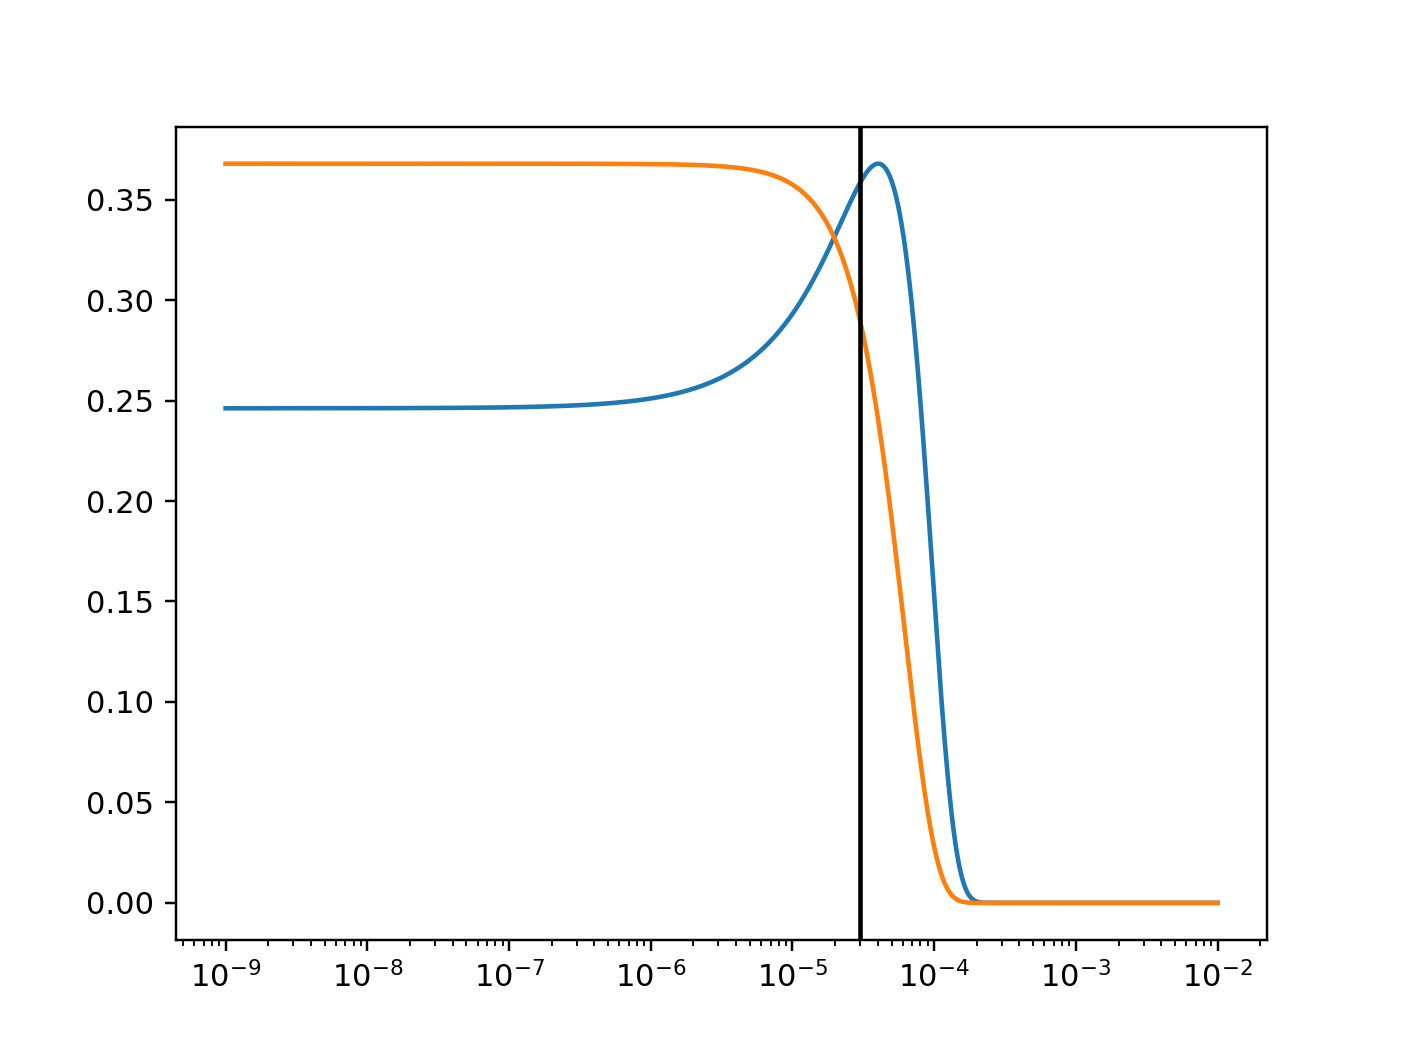

[]

In [72]:
L=np.arange(Lmax+1)
clmodel=np.zeros(Lmax+1,np.float64)
clmodel[1:]=2.*pi/(L[1:]*(L[1:]+1))

def bire_lkl(A,Clobs,Nl,clthry,fsky,Lmax):
    L=np.arange(Lmax+1)
    var=(2./((2.*L+1)*fsky))*(0*clthry[:Lmax+1] + Nl[:Lmax+1])**2.
    chi2=np.sum((Clobs[1:Lmax+1]-Nl[1:Lmax+1]-A*clthry[1:Lmax+1])**2/var[1:Lmax+1])
    return chi2

Avals=np.logspace(-9,-2,1000)

chi1=np.zeros_like(Avals)
chi2=np.zeros_like(Avals)
for i,A in enumerate(Avals):
    chi1[i]=bire_lkl(A,eb1.Cl_rec_alpha,eb1.N_L,clmodel,1.,512)
    chi2[i]=bire_lkl(A,eb2.Cl_rec_alpha,eb2.N_L,clmodel,1.,512)
    
    
chi1=chi1/min(chi1)
chi2=chi2/min(chi2)
figure()
plot(Avals,exp(-chi1))
plot(Avals,exp(-chi2))
axvline(3e-5,color="black")
semilogx()

# Testing the effect of master corrections

<IPython.core.display.Javascript object>


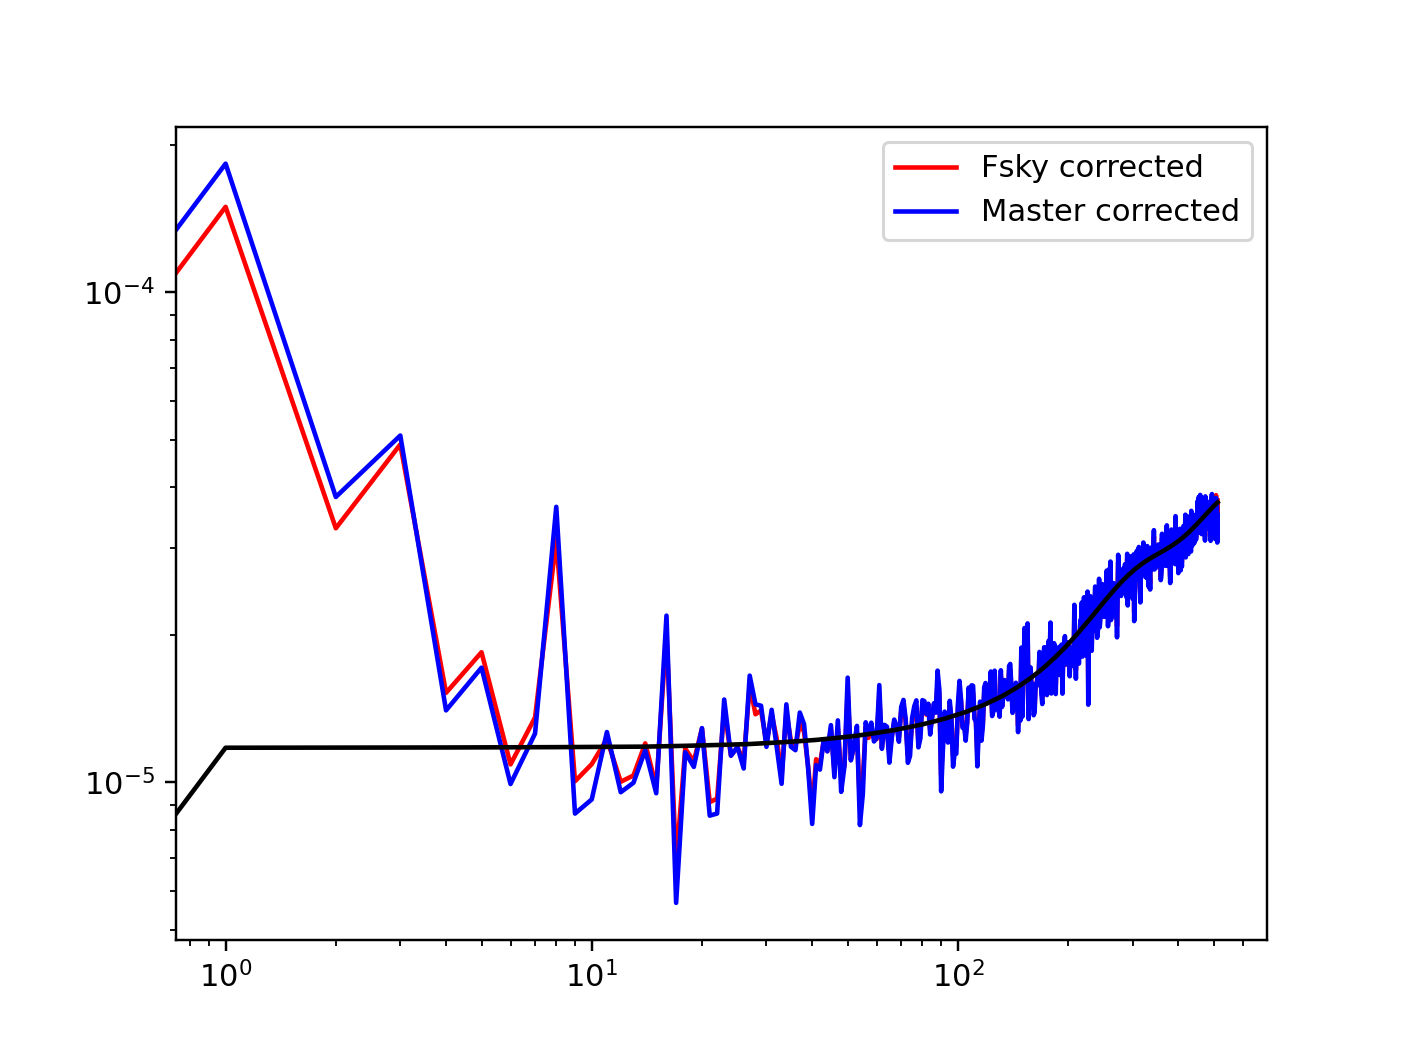

<IPython.core.display.Javascript object>


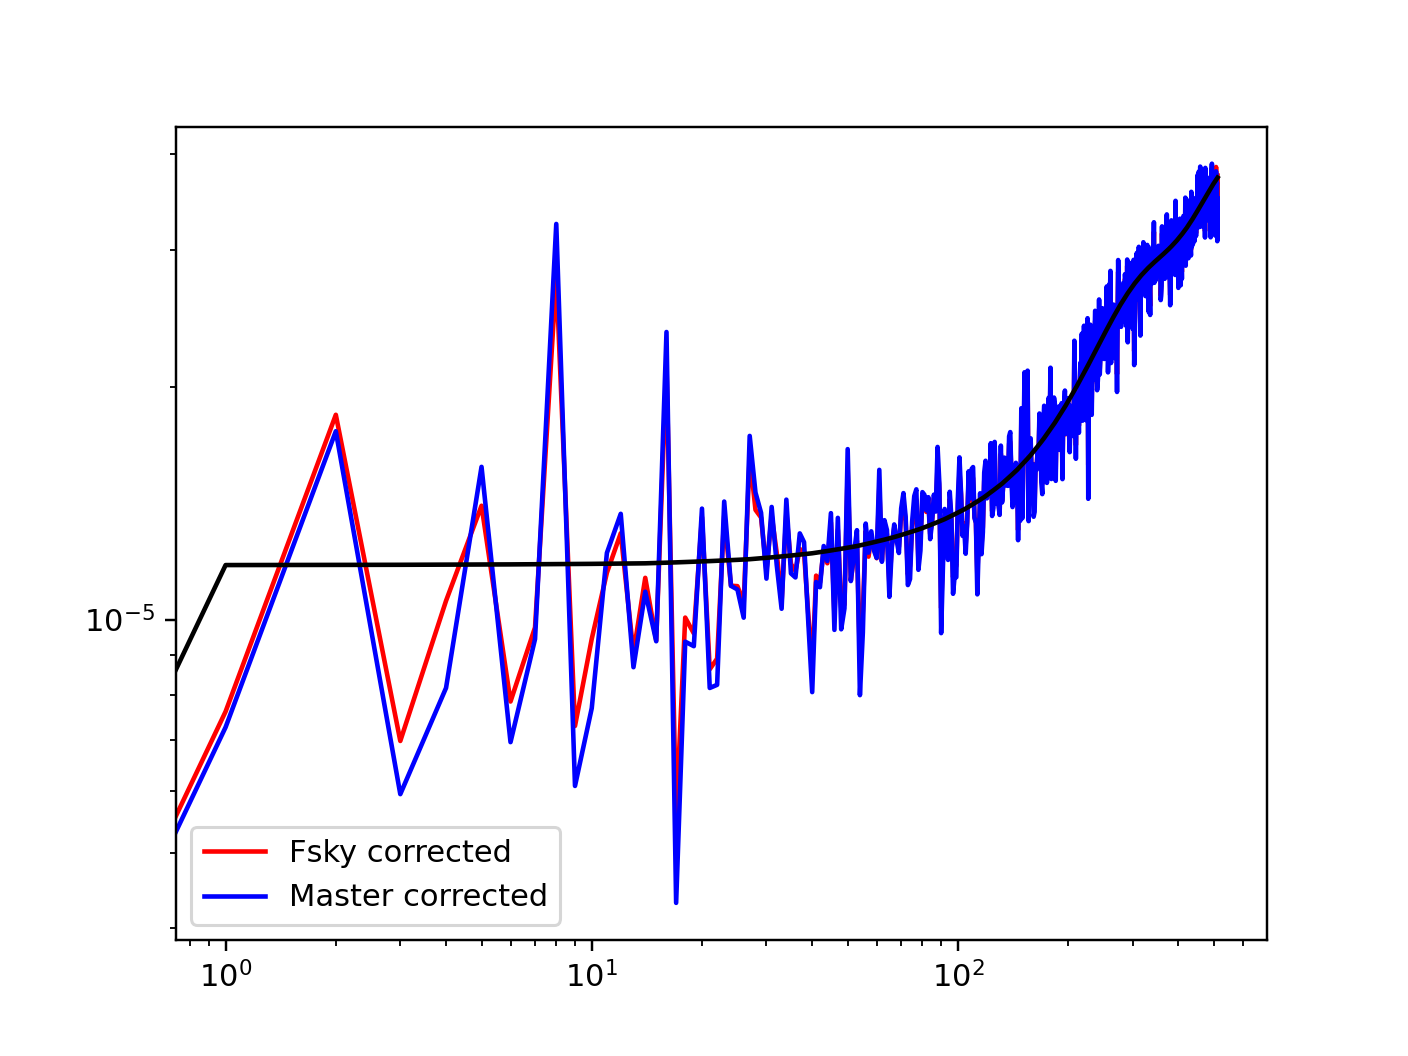

In [73]:
from modules.master import binned_master
bm=binned_master.binned_master(mask78,1,512,512,deltaell=1)

# mCl1=bm.return_mcs(eb1.Cl_rec_alpha*eb1.fsky)
# mCl2=bm.return_mcs(eb2.Cl_rec_alpha*eb2.fsky)

mCl1=bm.return_mcs(h.alm2cl(h.map2alm(eb1.rec_alpha*mask78,lmax=512)))
mCl2=bm.return_mcs(h.alm2cl(h.map2alm(eb2.rec_alpha*mask78,lmax=512)))

figure()
plot(eb1.Cl_rec_alpha,"r-",label="Fsky corrected")
plot(mCl1,"b-",label="Master corrected")
plot(eb1.N_L,"k-")
loglog()
legend()

figure()
plot(eb2.Cl_rec_alpha,"r-",label="Fsky corrected")
plot(mCl2,"b-",label="Master corrected")
plot(eb1.N_L,"k-")
loglog()
legend()



<IPython.core.display.Javascript object>


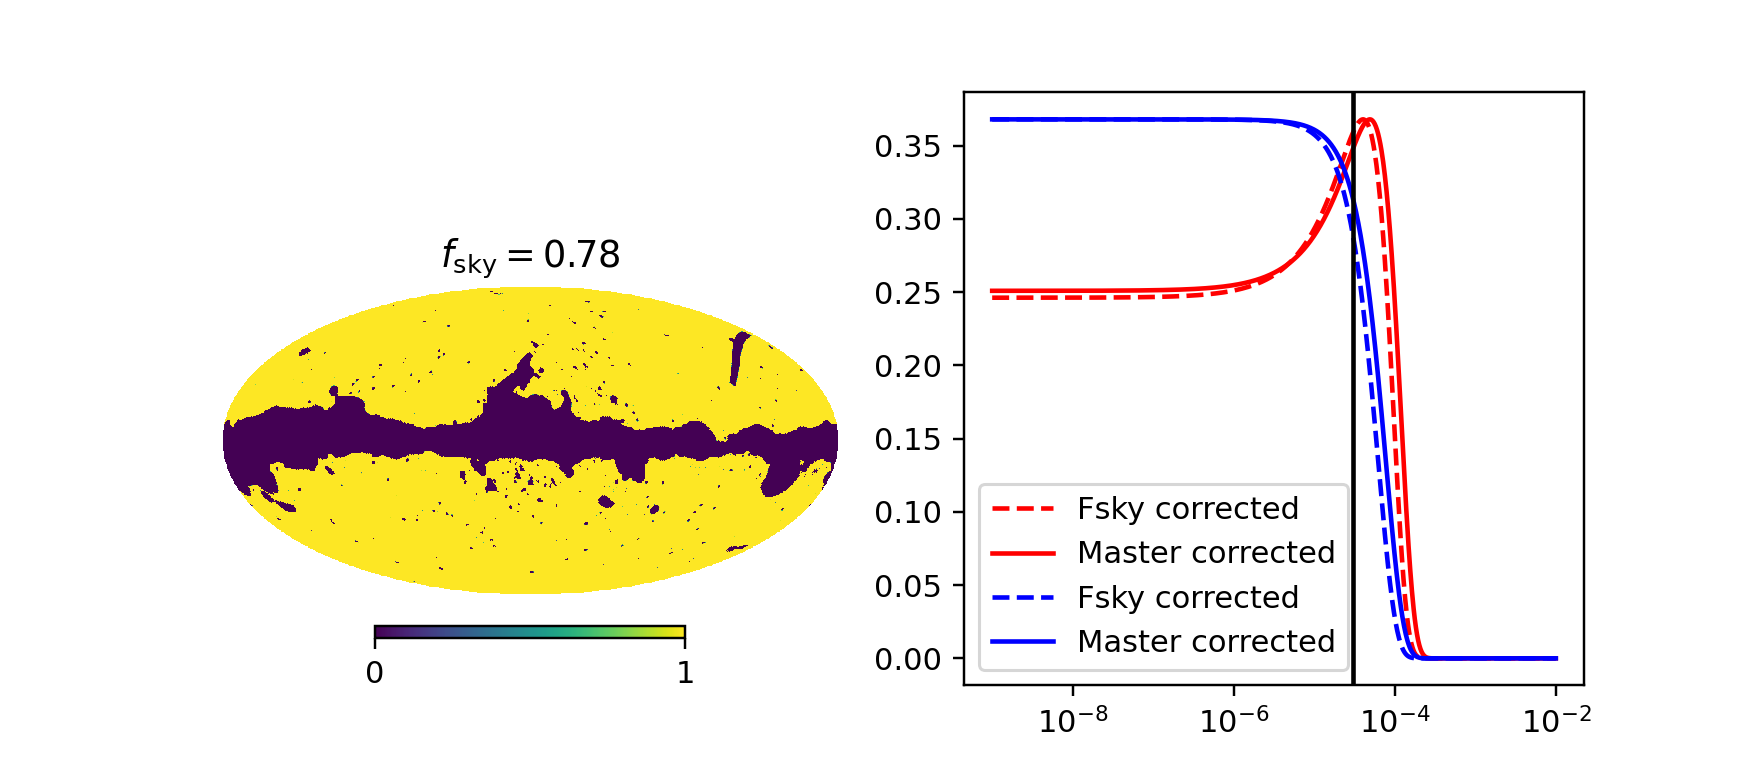

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This

In [74]:
L=np.arange(Lmax+1)
clmodel=np.zeros(Lmax+1,np.float64)
clmodel[1:]=2.*pi/(L[1:]*(L[1:]+1))

def bire_lkl(A,Clobs,Nl,clthry,fsky,Lmax):
    L=np.arange(Lmax+1)
    var=(2./((2.*L+1)*fsky))*Nl[:Lmax+1]**2.
    chi2=np.sum((Clobs[1:Lmax+1]-Nl[1:Lmax+1]-A*clthry[1:Lmax+1])**2/var[1:Lmax+1])
    return chi2

Avals=np.logspace(-9,-2,1000)

chi1=np.zeros_like(Avals)
chi2=np.zeros_like(Avals)
chi1m=np.zeros_like(Avals)
chi2m=np.zeros_like(Avals)
for i,A in enumerate(Avals):
    chi1[i]=bire_lkl(A,eb1.Cl_rec_alpha,eb1.N_L,clmodel,1.,512)
    chi1m[i]=bire_lkl(A,mCl1,eb1.N_L,clmodel,1.,512)
    chi2[i]=bire_lkl(A,eb2.Cl_rec_alpha,eb2.N_L,clmodel,1.,512)
    chi2m[i]=bire_lkl(A,mCl2,eb1.N_L,clmodel,1.,512)
    
    
chi1=chi1/min(chi1) ; chi2=chi2/min(chi2)
chi1m=chi1m/min(chi1m) ; chi2m=chi2m/min(chi2m)


fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=[8,3.5])
axes(ax1)
# h.mollview(mask72,title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),hold=True)
h.mollview(mask78,title=r"$f_{\rm sky}=$" + str(round(fsky78,2)),hold=True)
ax2.plot(Avals,exp(-chi1),"r--",label="Fsky corrected")
ax2.plot(Avals,exp(-chi1m),"r-",label="Master corrected")
ax2.plot(Avals,exp(-chi2),"b--",label="Fsky corrected")
ax2.plot(Avals,exp(-chi2m),"b-",label="Master corrected")
ax2.axvline(3e-5,color="black")
ax2.semilogx()
ax2.legend(loc=0)
# figname=figpath + "apo_mask_master_corr.pdf"
figname=figpath + "sharp_mask_master_corr.pdf"
savefig(figname,bbox_inches="tight")